# Quickstart: 簡単な設定でのシミュレーションと人工データセットの作成 (離散空間)

このノートブックでは，簡単な人工データセット上でのオフ方策学習(OPE)とオフライン強化学習(Offline RL)の実行例を紹介します．

特に、以下の5つの順番で解説していきます：

0. (シミュレーション環境の設定とオンライン強化学習)
1. 人工データの生成
2. オフライン強化学習
3. オフ方策評価とオフライン強化学習手法の評価
4. オフ方策評価手法の評価

このライブラリは，オンラインとオフラインの方策学習およびモデルベースのオフ方策評価の一部で [d3rlpy](https://github.com/takuseno/d3rlpy)のアルゴリズムを利用しています．
また、実装のワークフローは[Open Bandit Pipeline](https://github.com/st-tech/zr-obp)を参考にしています．

In [2]:
# SCOPE-RL モジュールのインポート
import scope_rl
from basicgym import BasicEnv
from scope_rl.dataset import SyntheticDataset
from scope_rl.policy import OnlineHead
from scope_rl.ope.online import (
    calc_on_policy_policy_value,
    visualize_on_policy_policy_value,
)

# d3rlpy アルゴリズムのインポート
from d3rlpy.algos import DiscreteRandomPolicyConfig
from d3rlpy.algos import RandomPolicyConfig as ContinuousRandomPolicyConfig
from d3rlpy.preprocessing import MinMaxObservationScaler, MinMaxActionScaler

# その他のライブラリのインポート
import gym
import torch

In [3]:
import pickle
from glob import glob
from tqdm import tqdm

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

In [4]:
# バージョン
print(scope_rl.__version__)

0.1.2


In [5]:
# random stateの設定
random_state = 12345

In [6]:
device = "cuda:0" if torch.cuda.is_available() else "cpu"

In [7]:
# logディレクトリ
from pathlib import Path
Path("logs/").mkdir(exist_ok=True)

In [8]:
# warnings
import warnings
warnings.simplefilter('ignore')

## 0. (シミュレーション環境の設定とオンライン強化学習)
まず初めに，今回用いる簡単な環境設定について紹介します．

#### 強化学習での環境のセットアップ
今回は簡単なシミュレーション環境上で，方策の獲得する累積報酬を最大化する問題を考えます．

この強化学習の問題を(部分観測)マルコフ決定過程((PO)MDP)として定式化します．
- `状態`: 状態観測（POMDPの場合は観測ノイズが発生）．
- `行動`: 強化学習エージェント (方策) により選択された行動．
- `報酬`: 状態と行動に応じて観測される報酬．

より詳細に環境の引数を確認したい場合は，以下を参照してください． [examples/quickstart/basic/basic_synthetic_customize_env_ja.ipynb](https://github.com/hakuhodo-technologies/scope-rl/blob/main/examples/quickstart/basic/basic_synthetic_customize_env_ja.ipynb).

In [9]:
# 環境のセットアップ
env = BasicEnv(random_state=random_state)

In [10]:
# ランダムに行動を選択するエージェントを定義
agent = OnlineHead(
    ContinuousRandomPolicyConfig().create(device=device),
    name="random",
)
agent.build_with_env(env)

In [11]:
# 環境とエージェントの相互作用
# 6行で強化学習の相互作用を記述できる
for episode in range(10):
    obs, info = env.reset()
    done = False

    while not done:
        action = agent.predict_online(obs)
        obs, reward, done, truncated, info = env.step(action)

In [12]:
# 状態
print(obs)
print(obs.shape)

[-0.37164978 -0.49943402  0.36963097 -0.28399277 -0.62862005]
(5,)


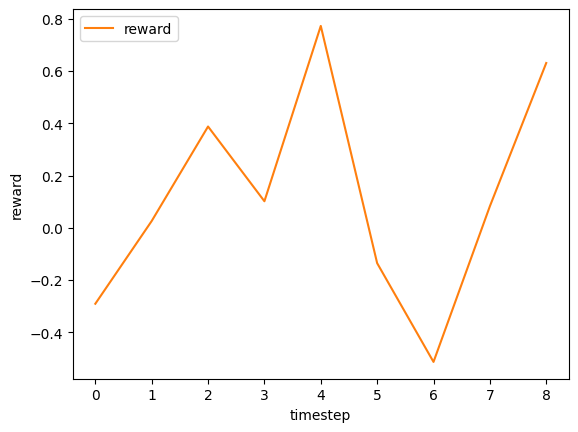

In [13]:
# ランダムエージェントの報酬の推移を可視化
obs, info = env.reset()
done = False
reward_list = []

while not done:
    action = agent.sample_action_online(obs)
    obs, reward, done, truncated, info = env.step(action)
    reward_list.append(reward)

# プロット
fig = plt.figure()
ax1 = fig.add_subplot(111)
ax1.plot(reward_list[:-1], label='reward', color='tab:orange')
ax1.set_xlabel('timestep')
ax1.set_ylabel('reward')
ax1.legend(loc='upper left')
plt.show()

#### オンライン強化学習と方策の比較
まずは方策価値のオンラインでの推定に基づき，オンライン強化学習で学習した方策とランダム方策を比較します．

In [14]:
# SCOPE-RLで実装されている離散行動空間に対する標準的な環境
env = gym.make("BasicEnv-discrete-v0")

In [15]:
from d3rlpy.algos import DoubleDQNConfig
from d3rlpy.models.encoders import VectorEncoderFactory
from d3rlpy.models.q_functions import MeanQFunctionFactory
from d3rlpy.dataset import create_fifo_replay_buffer
from d3rlpy.algos import LinearDecayEpsilonGreedy

# モデル
ddqn = DoubleDQNConfig(
    encoder_factory=VectorEncoderFactory(hidden_units=[30, 30]),
    q_func_factory=MeanQFunctionFactory(),
    target_update_interval=100,
).create(device=device)

# 再生バッファの設定
buffer = create_fifo_replay_buffer(
    limit=10000,
    env=env,
)

# 探索
explorer = LinearDecayEpsilonGreedy(
    start_epsilon=1.0,
    end_epsilon=0.3,
    duration=1000,
)

In [ ]:
# 学習の開始
# 事前学習したモデルを利用する場合はスキップ
ddqn.fit_online(
    env,
    buffer,
    explorer=explorer,
    eval_env=env,
    n_steps=100000,
    n_steps_per_epoch=1000,
    update_start_step=1000,
)

In [18]:
# モデルの保存
ddqn.save_model("d3rlpy_logs/ddqn.pt")

In [16]:
# モデルのリロード
ddqn.build_with_env(env)
ddqn.load_model("d3rlpy_logs/ddqn.pt")

Text(0, 0.5, 'episode reward')

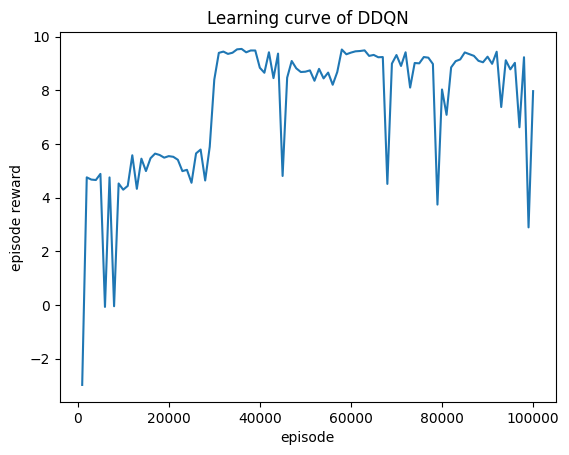

In [17]:
# モデルの学習曲線
log_path = sorted(glob("d3rlpy_logs/DoubleDQN_online_*/evaluation.csv"))[-1]
df = pd.read_csv(
    log_path, 
    usecols=[1,2],
    names=["train_episode", "episodic_rewards"]
)
plt.plot(df["train_episode"], df["episodic_rewards"])
plt.title("Learning curve of DDQN")
plt.xlabel("episode")
plt.ylabel("episode reward")

In [18]:
random = DiscreteRandomPolicyConfig().create(device=device)
random.build_with_env(env)

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

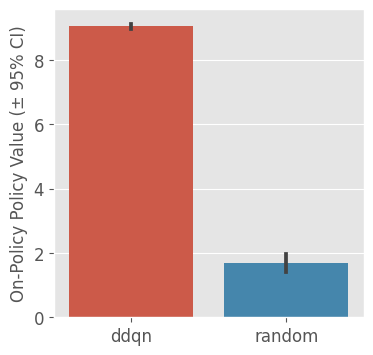

In [19]:
# オンラインでの性能比較
visualize_on_policy_policy_value(
    env=env,
    policies=[ddqn, random],
    policy_names=["ddqn", "random"],
    n_trajectories=100,
    random_state=random_state,
)

In [20]:
# ddqn方策のオンライン評価による方策価値
# ランダム方策より大幅に改善
ddqn_performance = calc_on_policy_policy_value(env, ddqn, n_trajectories=100, random_state=random_state)
random_performance = calc_on_policy_policy_value(env, random, n_trajectories=100, random_state=random_state)
print("relative improvement:", (ddqn_performance - random_performance) / random_performance)

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

relative improvement: 5.415675652184513


`scope_rl.ope.online`では，以下の関数を用いて方策の性能をオンラインで評価できます.

(統計量)
* `calc_on_policy_policy_value`
* `calc_on_policy_policy_value_interval`
* `calc_on_policy_variance`
* `calc_on_policy_conditional_value_at_risk`
* `calc_on_policy_policy_interquartile_range`
* `calc_on_policy_cumulative_distribution_function`

(可視化)
* `visualize_on_policy_policy_value`
* `visualize_on_policy_policy_value_with_variance`
* `visualize_on_policy_cumulative_distribution_function`
* `visualize_on_policy_conditional_value_at_risk`
* `visualize_on_policy_interquartile_range`

## 1. 人工データの生成
前章ではシミュレーション環境をオンライン環境とみなし，どのようにどのようにオンライン強化学習やオンラインでの性能評価を行うか確認しました．今回のようにシミュレーション環境上では簡単にエージェントを学習することができますが，実環境でオンラインのデータ収集や逐次的意思決定を行うことにはリスクを伴います．そこでオフライン強化学習ではデータ収集方策$\pi_0$から集められた以下のオフラインのログデータのみを利用することで，新たな方策を学習することを考えます．

$$\mathcal{D}_0 := \{ \{ s_t, a_t, s_{t+1}, r_t \}_{t=1}^T \}_{i=1}^n \sim \prod_{i=1}^n d_{s_0}(s_0) \prod_{t=1}^T \pi_0(a_t | s_t) p(s_{t+1} | s_t, a_t) p(r_t | s_t, a_t),$$

ここで $s_t \in \mathcal{S}$ は時刻$t$で観測された状態，$a_t$ はデータ収集方策 $\pi_0$によって選択された行動，$r_t$は状態と行動に応じて観測された報酬を表します．

SCOPE-RLでは人工データを簡単に生成するデータセットモジュールクラスとして `SyntheticDataset`を実装しており，`SyntheticDataset` は以下の引数を持っています:
- `env`: 強化学習の（シミュレーション）環境．
- `max_episode_steps`: 一つのエピソードにおける連続意思決定の数（上限）．

In [21]:
# SCOPE-RLから必要なモジュールをインポート
from scope_rl.policy import EpsilonGreedyHead

In [22]:
behavior_policy = EpsilonGreedyHead(
    ddqn, 
    n_actions=env.action_space.n,
    epsilon=0.3,
    name="ddqn_epsilon_0.3",
    random_state=random_state,
)

In [23]:
# データセットクラスの初期化
dataset = SyntheticDataset(
    env=env,
    max_episode_steps=env.step_per_episode,
)

In [ ]:
# データ収集方策によってログデータを集める
# ログデータがある存在する場合はスキップ
train_logged_dataset = dataset.obtain_episodes(
    behavior_policies=behavior_policy,
    n_trajectories=10000, 
    obtain_info=False,
    random_state=random_state,
)
test_logged_dataset = dataset.obtain_episodes(
    behavior_policies=behavior_policy,
    n_trajectories=10000, 
    obtain_info=False,
    random_state=random_state + 1,
)

In [25]:
train_logged_dataset

{'size': 100000,
 'n_trajectories': 10000,
 'step_per_trajectory': 10,
 'action_type': 'discrete',
 'n_actions': 10,
 'action_dim': None,
 'action_meaning': None,
 'action_keys': None,
 'state_dim': 5,
 'state_keys': None,
 'state': array([[ 0.46692103, -0.60091272,  0.12748286,  0.10612129,  0.62719618],
        [ 0.00305434,  0.25886564,  0.94683458, -0.18441597, -0.04974207],
        [ 0.09209668,  0.18060315, -0.96557628, -0.16297735,  0.00123719],
        ...,
        [-0.32659665, -0.4457801 ,  0.12418311, -0.55321285,  0.61085909],
        [ 0.91297429, -0.08570925,  0.24184222, -0.15626001,  0.27609242],
        [-0.38500003,  0.06259195,  0.51752316, -0.76154405,  0.00881301]]),
 'action': array([6, 1, 6, ..., 8, 6, 5]),
 'reward': array([ 0.85571015, -0.27916946,  0.63759116, ...,  0.03190668,
         0.79813161,  0.60196688]),
 'done': array([0., 0., 0., ..., 0., 0., 1.]),
 'terminal': array([0., 0., 0., ..., 0., 0., 1.]),
 'info': {},
 'pscore': array([0.73, 0.03, 0.73, ..

In [29]:
with open("logs/train_dataset_discrete_ddqn.pkl", "wb") as f:
    pickle.dump(train_logged_dataset, f)
with open("logs/test_dataset_discrete_ddqn.pkl", "wb") as f:
    pickle.dump(test_logged_dataset, f)

In [26]:
with open("logs/train_dataset_discrete_ddqn.pkl", "rb") as f:
    train_logged_dataset = pickle.load(f)
with open("logs/test_dataset_discrete_ddqn.pkl", "rb") as f:
    test_logged_dataset = pickle.load(f)

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

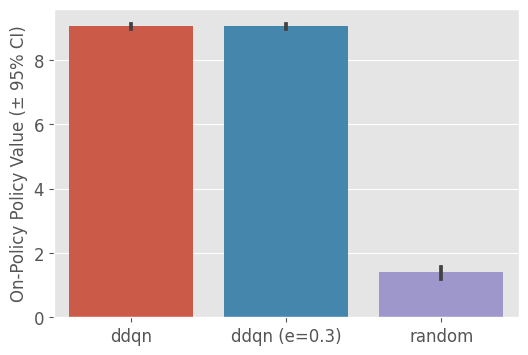

In [27]:
# オンラインでの性能比較

visualize_on_policy_policy_value(
    env=env,
    policies=[ddqn, behavior_policy, random],
    policy_names=["ddqn", "ddqn (e=0.3)", "random"],
    n_trajectories=100,
    random_state=random_state,
)

より詳細にデータ収集と可視化について知りたい場合は，以下を参照してください．[examples/quickstart/basic_synthetic_data_collection.ipynb](https://github.com/negocia-inc/basic_reinforcement_learing/blob/ope/examples/quickstart/basic_synthetic_data_collection.ipynb).

## 2. オフライン強化学習
この章では実環境と相互作用せずに，ログデータのみから新しい方策を学習する方法を紹介します．
オフライン強化学習のアルゴリズムは [d3rlpy](https://github.com/takuseno/d3rlpy)に実装されているものを利用します．

In [29]:
# d3rlpyのモジュールのインポート
from d3rlpy.dataset import MDPDataset
from d3rlpy.algos import DiscreteCQLConfig

In [30]:
offlinerl_dataset = MDPDataset(
    observations=train_logged_dataset["state"],
    actions=train_logged_dataset["action"],
    rewards=train_logged_dataset["reward"],
    terminals=train_logged_dataset["done"],
)

In [31]:
# Conservative Q-Learning 方策を利用
cql = DiscreteCQLConfig(
    encoder_factory=VectorEncoderFactory(hidden_units=[30, 30]),
    q_func_factory=MeanQFunctionFactory(),
).create(device=device)

In [ ]:
cql.fit(
    offlinerl_dataset,
    n_steps=10000,
)

In [33]:
# モデルの保存
cql.save_model("d3rlpy_logs/cql_discrete.pt")

In [35]:
# モデルのリロード
cql.build_with_env(env)
cql.load_model("d3rlpy_logs/cql_discrete.pt")

2023-07-22 15:50:43 [warning  ] Parameters will be reinitialized.


[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

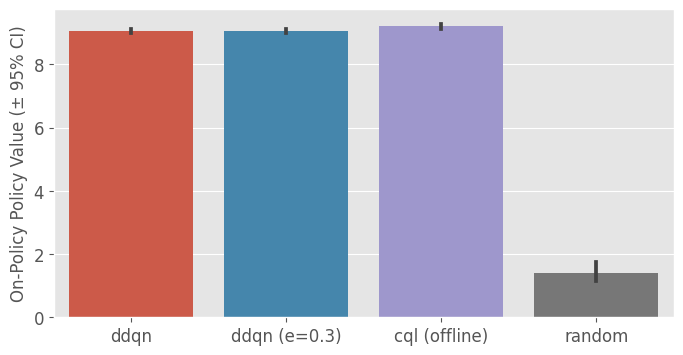

In [36]:
# オンラインでの性能比較
# オフラインで学習した方策もオンラインで学習した方策と同等程度の性能を達成

visualize_on_policy_policy_value(
    env=env,
    policies=[ddqn, behavior_policy, cql, random],
    policy_names=["ddqn", "ddqn (e=0.3)", "cql (offline)", "random"],
    n_trajectories=100,
    random_state=random_state,
)

## 3. オフ方策評価とオフライン強化学習手法の評価
前章ではオンラインの性能評価 (A/Bテスト) により学習した方策の性能を確認しました．しかし，実務においては方策の性能が悪い場合に顧客の満足度を毀損してしまうなど，A/Bテストにも大きなリスクが伴うことが知られています．ここで学習した方策が実環境でどのように動作するかを事前に見積もるために，オフラインでの方策性能の評価を行います．

#### 推定目標
ここでは，方策の期待性能 (*方策価値*) を推定します．

$$ V(\pi) := \mathbb{E}\left[\sum_{t=1}^T \gamma^{t-1} r_t \mid \pi \right] $$

In [37]:
# SCOPE-RLからのopeモジュールのインポート
from scope_rl.ope import CreateOPEInput
from scope_rl.ope import OffPolicyEvaluation as OPE
from scope_rl.ope.discrete import DirectMethod as DM
from scope_rl.ope.discrete import TrajectoryWiseImportanceSampling as TIS
from scope_rl.ope.discrete import PerDecisionImportanceSampling as PDIS
from scope_rl.ope.discrete import DoublyRobust as DR
from scope_rl.ope.discrete import SelfNormalizedTIS as SNTIS
from scope_rl.ope.discrete import SelfNormalizedPDIS as SNPDIS
from scope_rl.ope.discrete import SelfNormalizedDR as SNDR

In [38]:
# 評価方策を定義
cql_ = EpsilonGreedyHead(base_policy=cql, n_actions=env.action_space.n, name="cql", epsilon=0.0, random_state=random_state)
ddqn_ = EpsilonGreedyHead(base_policy=ddqn, n_actions=env.action_space.n, name="ddqn", epsilon=0.0, random_state=random_state)
random_ = EpsilonGreedyHead(base_policy=random, n_actions=env.action_space.n, name="random", epsilon=1.0, random_state=random_state)
evaluation_policies = [cql_, ddqn_, random_]

In [39]:
# まずOPEのインプットを準備
prep = CreateOPEInput(
    env=env,
    model_args={
        "fqe": {
            "encoder_factory": VectorEncoderFactory(hidden_units=[30, 30]),
            "q_func_factory": MeanQFunctionFactory(),
            "learning_rate": 1e-4,
        }
    },
    state_scaler=MinMaxObservationScaler(
        minimum=test_logged_dataset["state"].min(axis=0),
        maximum=test_logged_dataset["state"].max(axis=0),
    ),
)

In [ ]:
# 計算に時間がかかります
input_dict = prep.obtain_whole_inputs(
    logged_dataset=test_logged_dataset,
    evaluation_policies=evaluation_policies,
    require_value_prediction=True,
    n_trajectories_on_policy_evaluation=100,
    random_state=random_state,
)

In [41]:
with open("logs/ope_input_dict_discrete.pkl", "wb") as f:
    pickle.dump(input_dict, f)

In [42]:
with open("logs/ope_input_dict_discrete.pkl", "rb") as f:
    input_dict = pickle.load(f)

In [43]:
ope = OPE(
    logged_dataset=test_logged_dataset,
    ope_estimators=[DM(), TIS(), PDIS(), DR(), SNTIS(), SNPDIS(), SNDR()],
)

In [44]:
# opeによる性能評価
policy_value_df_dict, policy_value_interval_df_dict = ope.summarize_off_policy_estimates(input_dict, random_state=random_state)

In [45]:
# 推定した方策性能
policy_value_df_dict

{'cql':            policy_value  relative_policy_value
 on_policy      9.200653               1.000000
 dm            77.463266               8.419323
 tis            9.089277               0.987895
 pdis           8.246665               0.896313
 dr            -1.676666              -0.182233
 sntis          8.070726               0.877191
 snpdis         8.171590               0.888153
 sndr           8.128708               0.883492,
 'ddqn':            policy_value  relative_policy_value
 on_policy      9.049250               1.000000
 dm            81.488178               9.004965
 tis            8.298840               0.917075
 pdis           8.185875               0.904591
 dr             5.272623               0.582659
 sntis          8.014676               0.885673
 snpdis         8.004578               0.884557
 sndr           8.000598               0.884117,
 'random':            policy_value  relative_policy_value
 on_policy      1.651448               1.000000
 dm          

In [46]:
# 推定した方策性能の信頼区間
policy_value_interval_df_dict

{'cql':                 mean  95.0% CI (lower)  95.0% CI (upper)
 on_policy   9.195161          9.127411          9.257257
 dm         77.464236         77.443474         77.486047
 tis         9.170793          7.349644         11.291644
 pdis        8.292443          7.659023          8.969326
 dr         -2.337128        -22.840996         15.046490
 sntis       8.143107          6.526037         10.026294
 snpdis      8.216275          7.593924          8.878023
 sndr        7.546079        -10.620825         22.961161,
 'ddqn':                 mean  95.0% CI (lower)  95.0% CI (upper)
 on_policy   9.044297          8.980962          9.106620
 dm         81.487609         81.464789         81.520410
 tis         8.345816          7.675982          9.038348
 pdis        8.219210          7.899196          8.513716
 dr          4.785452         -2.102822         11.592710
 sntis       8.060043          7.413145          8.728863
 snpdis      8.037118          7.725513          8.32397

## 4. オフ方策評価手法の評価
ope推定量がどのくらい方策価値を推定できているかを評価します．

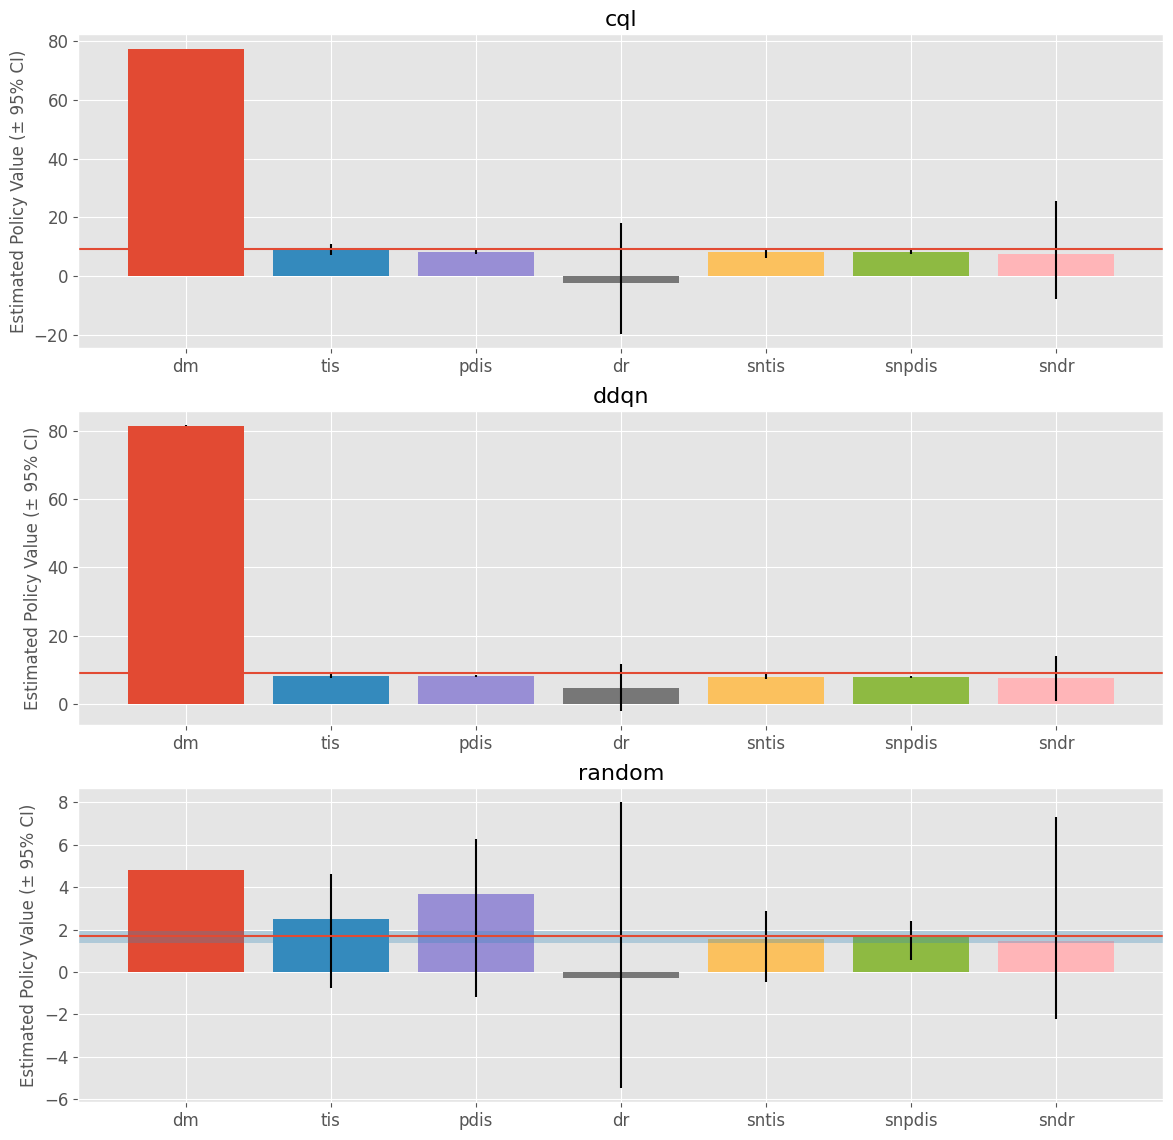

In [47]:
# opeの結果の比較・可視化
# 今回の例ではDMは, 推定誤差による大きなバイアスが発生しています
ope.visualize_off_policy_estimates(input_dict, random_state=random_state, sharey=False)

In [48]:
# OPEの推定の正確さを測るために2乗誤差を利用します
eval_metric_ope_df = ope.evaluate_performance_of_ope_estimators(
    input_dict, 
    metric="se",
    return_by_dataframe=True,
)
eval_metric_ope_df

,cql,ddqn,random
dm,4659.784284,5247.398208,10.073530
tis,0.012405,0.563116,0.762632
pdis,0.910094,0.745418,4.287693
dr,118.316067,14.262911,4.022213
sntis,1.276736,1.070344,0.004598
snpdis,1.058970,1.091340,0.002478
sndr,1.149067,1.099672,0.055249


OPEのより発展的なトピック(累積分布関数の推定など) やオフ方策選択 (OPS) は，以下を参照してください．[examples/quickstart/basic/basic_synthetic_discrete_advanced.ipynb](https://github.com/hakuhodo-technologies/scope-rl/blob/main/examples/quickstart/basic/basic_synthetic_discrete_advanced.ipynb). 

OPEのより発展的な推定量 (state(-action) marginal estimators や double reinforcement learningなど) は，以下を参照してください． [examples/quickstart/basic/basic_synthetic_discrete_zoo.ipynb](https://github.com/hakuhodo-technologies/scope-rl/blob/ope/examples/quickstart/basic/basic_synthetic_discrete_zoo.ipynb). 

連続的な行動空間に対する例は，以下を参照してください． [examples/quickstart/basic/basic_synthetic_continuous_basic.ipynb](https://github.com/hakuhodo-technologies/scope-rl/blob/main/examples/quickstart/basic/basic_synthetic_continuous_basic.ipynb).

## 参考文献

- Yuta Saito, Shunsuke Aihara, Megumi Matsutani, and Yusuke Narita. \
"Open Bandit Dataset and Pipeline: Towards Realistic and Reproducible Off-Policy Evaluation.", 2021.

- Takuma Seno and Michita Imai. \
"d3rlpy: An Offline Deep Reinforcement Library.", 2021.

- Sergey Levine, Aviral Kumar, George Tucker, and Justin Fu. \
"Offline Reinforcement Learning: Tutorial, Review, and Perspectives on Open Problems." 2020.

- Aviral Kumar, Aurick Zhou, George Tucker, and Sergey Levine. \
"Conservative Q-Learning for Offline Reinforcement Learning.", 2020.

- Nathan Kallus and Masatoshi Uehara. \
"Intrinsically Efficient, Stable, and Bounded Off-Policy Evaluation for Reinforcement Learning.", 2019.

- Hoang Le, Cameron Voloshin, and Yisong Yue. \
"Batch Policy Learning under Constraints.", 2019.

- Di Wu, Xiujun Chen, Xun Yang, Hao Wang, Qing Tan, Xiaoxun Zhang, Jian Xu, and Kun Gai. \
"Budget Constrained Bidding by Model-free Reinforcement Learning in Display Advertising.", 2018.

- Jun Zhao, Guang Qiu, Ziyu Guan, Wei Zhao, and Xiaofei He. \
"Deep Reinforcement Learning for Sponsored Search Real-time Bidding.", 2018.

- Nan Jiang and Lihong Li. \
"Doubly Robust Off-policy Value Evaluation for Reinforcement Learning.", 2016.

- Philip S. Thomas and Emma Brunskill. \
"Data-Efficient Off-Policy Policy Evaluation for Reinforcement Learning.", 2016.

- Greg Brockman, Vicki Cheung, Ludwig Pettersson, Jonas Schneider, John Schulman, Jie Tang, and Wojciech Zaremba. \
"OpenAI Gym.", 2016.

- Adith Swaminathan and Thorsten Joachims. \
"The Self-Normalized Estimator for Counterfactual Learning.", 2015.

- Hado van Hasselt, Arthur Guez, and David Silver. \
"Deep Reinforcement Learning with Double Q-learning.", 2015.

- Miroslav Dudík, Dumitru Erhan, John Langford, and Lihong Li. \
"Doubly Robust Policy Evaluation and Optimization.", 2014.

- Alex Strehl, John Langford, Sham Kakade, and Lihong Li. \
"Learning from Logged Implicit Exploration Data.", 2010.

- Alina Beygelzimer and John Langford. \
"The Offset Tree for Learning with Partial Labels.", 2009.

- Doina Precup, Richard S. Sutton, and Satinder P. Singh. \
"Eligibility Traces for Off-Policy Policy Evaluation.", 2000.